In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)



Running on TPU  grpc://10.108.97.178:8470
Number of replicas: 8


In [25]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 512
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 4 * strategy.num_replicas_in_sync
EPOCHS = 10

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [4]:
train_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/train.csv"
train_set = pd.read_csv(train_file_path)
train_set.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Data Preprocessing

In [5]:
train_set_prova = train_set.drop(columns=["TITLE", "ABSTRACT", "ID"])
train_set["category"] = train_set_prova.idxmax(axis=1).str.lower()
train_set.drop(columns=["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance", "ID"], inplace=True)
train_set.head()

,TITLE,ABSTRACT,category
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,computer science
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,computer science
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,mathematics
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,mathematics
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,computer science


# Joining the title and abstract into a single text column

In [6]:
train_set["text"] = train_set["TITLE"] + " " + train_set["ABSTRACT"]
train_set.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

In [7]:
X_data = train_set[['text']].to_numpy()
y_data = train_set[['category']].to_numpy()
print(f"len X_data: {len(X_data)}, len y_data: {len(y_data)}")

len X_data: 20972, len y_data: 20972


In [8]:
X_data.shape

(20972, 1)

# Dataset Analysis

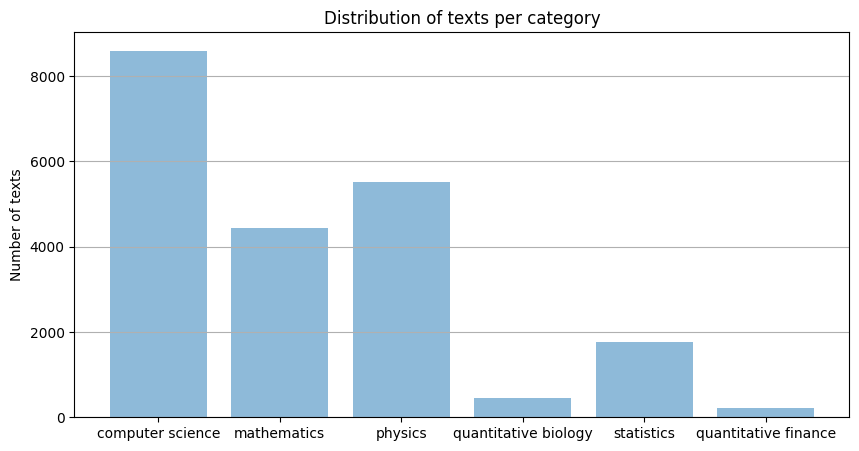

Counter({'computer science': 8594, 'physics': 5521, 'mathematics': 4436, 'statistics': 1765, 'quantitative biology': 447, 'quantitative finance': 209})


In [9]:
categories = train_set[['category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [10]:
def calculate_stats(df, split_char=' '):
    categories = df['category'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['category']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

def display_lengths_histograms(df_stats, n_cols=4):
    categories = train_set['category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 10))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [11]:
df_stats = calculate_stats(train_set)
df_stats['per_category']

,lengths,mean,stdev
computer science,"[270, 81, 146, 267, 143, 128, 142, 207, 119, 1...",169.130673,54.803028
mathematics,"[108, 120, 222, 57, 60, 159, 77, 164, 68, 109,...",115.883904,57.079053
physics,"[122, 133, 138, 224, 147, 144, 272, 286, 104, ...",172.434523,61.436704
quantitative biology,"[158, 238, 113, 202, 119, 146, 162, 275, 97, 1...",189.172260,59.060692
statistics,"[213, 188, 94, 177, 171, 150, 112, 167, 291, 1...",168.471388,54.872041
quantitative finance,"[109, 149, 148, 146, 91, 110, 36, 133, 174, 16...",150.119617,55.745042


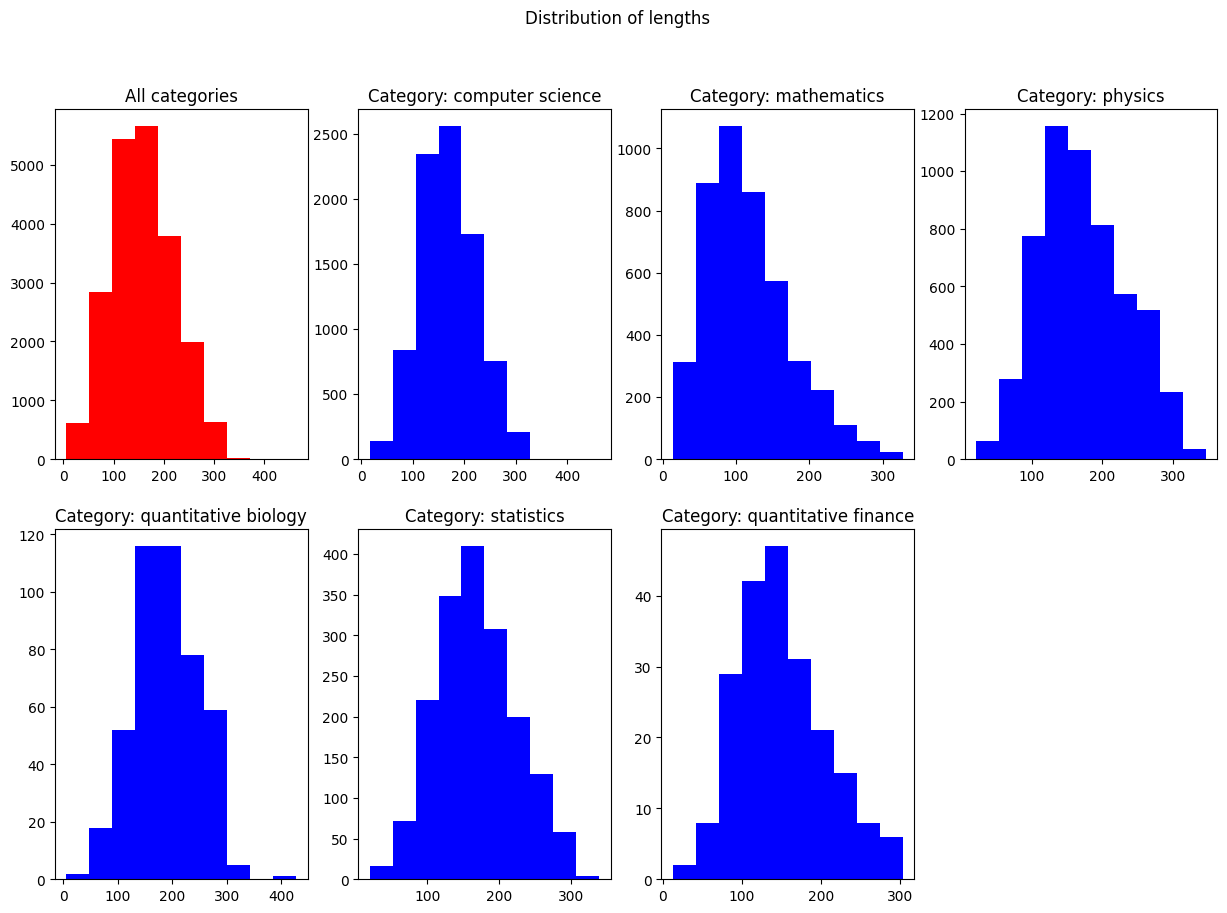

In [12]:
display_lengths_histograms(df_stats)

In [13]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = train_set['category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

Texts in dataset: 20972
Number of categories: 6


# Tokenization

In [14]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [15]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c[0] in category_to_id:
        category_id = category_to_id[c[0]]
    else:
        category_id = len(category_to_id)
        category_to_id[c[0]] = category_id
        category_to_name[category_id] = c[0]

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'computer science',
 1: 'mathematics',
 2: 'physics',
 3: 'quantitative biology',
 4: 'statistics',
 5: 'quantitative finance'}

In [16]:
y_data

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=object)

In [17]:
X_data = X_data.flatten()
y_data = y_data.flatten()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [19]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)


y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

# RoBERTa Model Creation

In [26]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model



In [27]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

In [28]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/10


525/525 [==============================] - 262s 322ms/step - loss: 6.2618 - accuracy: 0.3207 - val_loss: 1.5613 - val_accuracy: 0.4033
Epoch 2/10
525/525 [==============================] - 110s 210ms/step - loss: 1.5115 - accuracy: 0.3505 - val_loss: 1.4074 - val_accuracy: 0.4033
Epoch 3/10
525/525 [==============================] - 111s 211ms/step - loss: 1.4582 - accuracy: 0.3747 - val_loss: 1.4197 - val_accuracy: 0.4033
Epoch 4/10
525/525 [==============================] - 111s 211ms/step - loss: 1.4442 - accuracy: 0.3802 - val_loss: 1.4146 - val_accuracy: 0.2694
Epoch 5/10
525/525 [==============================] - 110s 210ms/step - loss: 1.4224 - accuracy: 0.3892 - val_loss: 1.3922 - val_accuracy: 0.4033
Epoch 6/10
525/525 [==============================] - 110s 210ms/step - loss: 1.4006 - accuracy: 0.3992 - val_loss: 1.3880 - val_accuracy: 0.4033
Epoch 7/10
525/525 [==============================] - 110s 210ms/step - loss: 1.3938 - accuracy: 0.4098 - val_loss: 1.3906 - val_accura

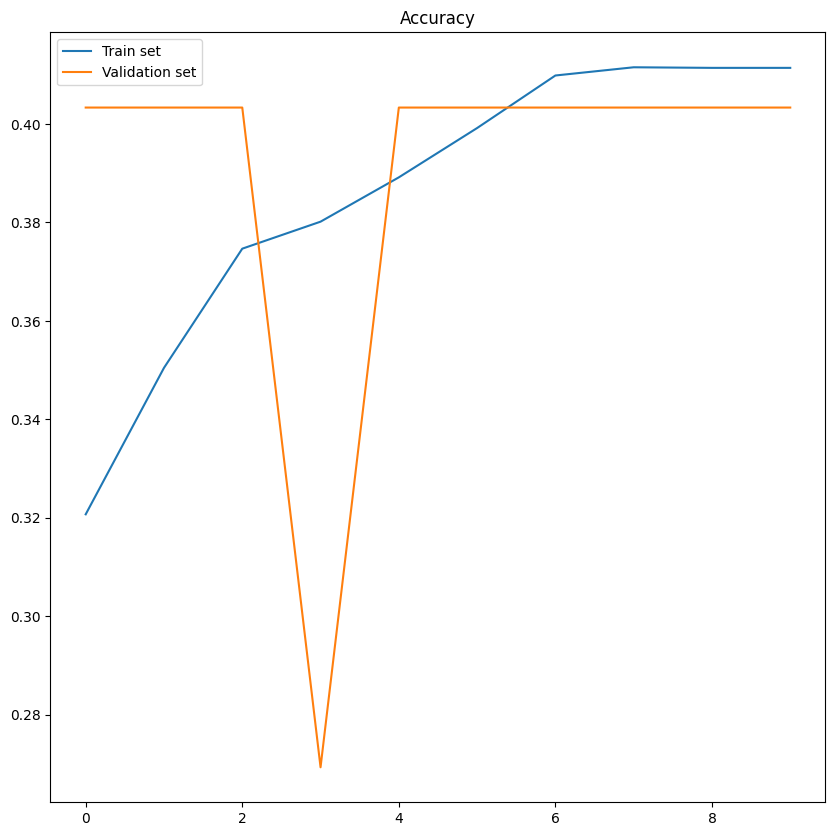

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()